<a href="https://colab.research.google.com/github/lak-sh-mi/DeepWalk/blob/master/V3_workloadPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
csv_file = 'invocation_count_zscale.csv'
df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
df = df.groupby('period').sum()
sub_df = df['1998-06-30 08:00:01':'1998-07-01 08:00:00']

sns.set()

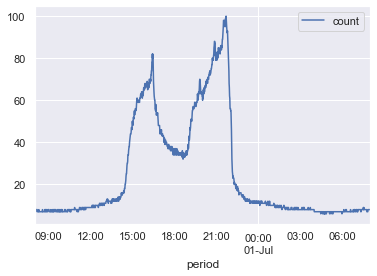

[8 7 7 ... 8 8 8]


In [ ]:
scaled_max = 100
scaled_sub_df = (sub_df / sub_df['count'].max() * scaled_max).apply(lambda x: round(x))
scaled_sub_df['count'] = scaled_sub_df['count'].apply(lambda x: int(x))

scaled_sub_df.plot()
plt.savefig('sample.png')
plt.show()

print(scaled_sub_df['count'].values)


In [ ]:
df

,count
period,
1998-04-30 21:30:00,2
1998-04-30 21:31:00,11
1998-04-30 21:32:00,16
1998-04-30 21:33:00,7
1998-04-30 21:34:00,3
...,...
1998-07-26 21:55:00,777
1998-07-26 21:56:00,764
1998-07-26 21:57:00,821


In [ ]:
import sklearn.metrics as metrics

In [ ]:
def regression_metrics(y_true,y_pred):
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_score = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    msle = 0.0
    try:
        msle = metrics.mean_squared_log_error(y_true, y_pred)
    except ValueError:
        msle = 0.0
        print(ValueError)
    median_absolute_error = metrics.median_absolute_error(y_true,y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print('explained variance: ', round(explained_variance, 4))
    print('mean_absolute_score: ', round(mean_absolute_score, 4))
    print('mean squred error: ', round(mse, 4))
    print('mean squared log error: ', round(msle, 4))
    print('median absolute error: ', round(median_absolute_error, 4))
    print('r-squared: ', round(r2, 4))

In [ ]:
orig_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
# orig_df[['count']]
traffic_df = orig_df[['count']]
traffic_df.loc[:,'previous'] = traffic_df.loc[:,'count'].shift(15)
traffic_df.loc[:,'difference'] = traffic_df.loc[:,'previous'].diff(periods=1)
traffic_df = traffic_df.dropna()
traffic_df

,count,previous,difference
period,,,
1998-04-30 21:46:00,-0.560473,-0.560109,0.000467
1998-04-30 21:47:00,-0.559019,-0.559849,0.000260
1998-04-30 21:48:00,-0.559901,-0.560317,-0.000467
1998-04-30 21:49:00,-0.560576,-0.560525,-0.000208
1998-04-30 21:50:00,-0.560576,-0.560576,-0.000052
...,...,...,...
1998-07-26 21:55:00,-0.520329,-0.528223,-0.001766
1998-07-26 21:56:00,-0.521005,-0.518252,0.009971
1998-07-26 21:57:00,-0.518045,-0.525730,-0.007478


In [ ]:
# X_train = traffic_df[:'1998-05'].drop(['count'],axis = 1)
# y_train = traffic_df.loc[:'1998-05', 'count']

X_train = traffic_df.drop(['count'],axis = 1)
y_train = traffic_df.loc[:, 'count']

# X_test = traffic_df['1998-06':'1998-06'].drop(['count'],axis = 1)
# y_test = traffic_df.loc['1998-06':'1998-06', 'count']

In [ ]:
y_train

period
1998-04-30 21:46:00   -0.560473
1998-04-30 21:47:00   -0.559019
1998-04-30 21:48:00   -0.559901
1998-04-30 21:49:00   -0.560576
1998-04-30 21:50:00   -0.560576
                         ...   
1998-07-26 21:55:00   -0.520329
1998-07-26 21:56:00   -0.521005
1998-07-26 21:57:00   -0.518045
1998-07-26 21:58:00   -0.532274
1998-07-26 21:59:00   -0.525419
Name: count, Length: 125284, dtype: float64

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver='lbfgs', max_iter=10000)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators=10)))
models.append(('SVR', SVR(gamma='auto')))

In [ ]:
results = []
names = []
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=30)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')

    results.append(cv_results)
    names.append(name)

    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


LR: -2.235510 (4.343533)
NN: -14.049136 (49.468207)
KNN: -2.928802 (5.774860)
RF: -3.725162 (6.967096)
SVR: -32.722975 (79.698762)


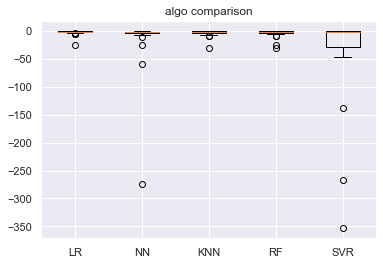

In [ ]:
plt.boxplot(results, labels=names)
plt.title('algo comparison')
plt.show()

From the cross validation scores above, it seems NN seems to be the best, followed by RF and then KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# kfold = KFold(n_splits=5,shuffle=True)

# for train_index, val_index in kfold.split(X_train, y_train):
#neural net
model = MLPRegressor(solver='lbfgs')
param_search = {
    'alpha' : [0.0001, 0.001, 0.01],
    'max_iter' : [1000, 10000, 100000],
}
# KNN
# model = KNeighborsRegressor(n_jobs=-1)
# param_search = {
#     'n_neighbors' : [3,5,10,20],
#     'weights' : ['uniform','distance'],
    # 'leaf_size' : [10,20,30,50],
    # 'p' : [1,2,3]
# }
# linear regressor
# model = LinearRegression(n_jobs=-1)
# param_search = {
#
# }
#random forest
# model = RandomForestRegressor(n_jobs=-1)
# param_search = {
#     'n_estimators' : [10,50,100],
#     'criterion' : ['mse','mae']
# }
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }
# tscv = TimeSeriesSplit(n_splits=30)
gsearch = GridSearchCV(estimator=model, cv=5, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [ ]:
#Prediction is done by/from the saved model
import pickle
filename = 'mlp15min.ZSCALE.sav'
pickle.dump(best_model, open(filename, 'wb'))
#
# best_model = pickle.load(open(filename, 'rb'))
# result = best.score(X_test, Y_test)
# print(result)

In [ ]:
print(best_score)

-0.09529441806080205


In [ ]:
#Error metrics
y_true = y_train.values
y_pred = best_model.predict(X_train)

regression_metrics(y_true, y_pred)

<class 'ValueError'>
explained variance:  0.9581
mean_absolute_score:  0.0578
mean squred error:  0.0419
mean squared log error:  0.0
median absolute error:  0.016
r-squared:  0.9581


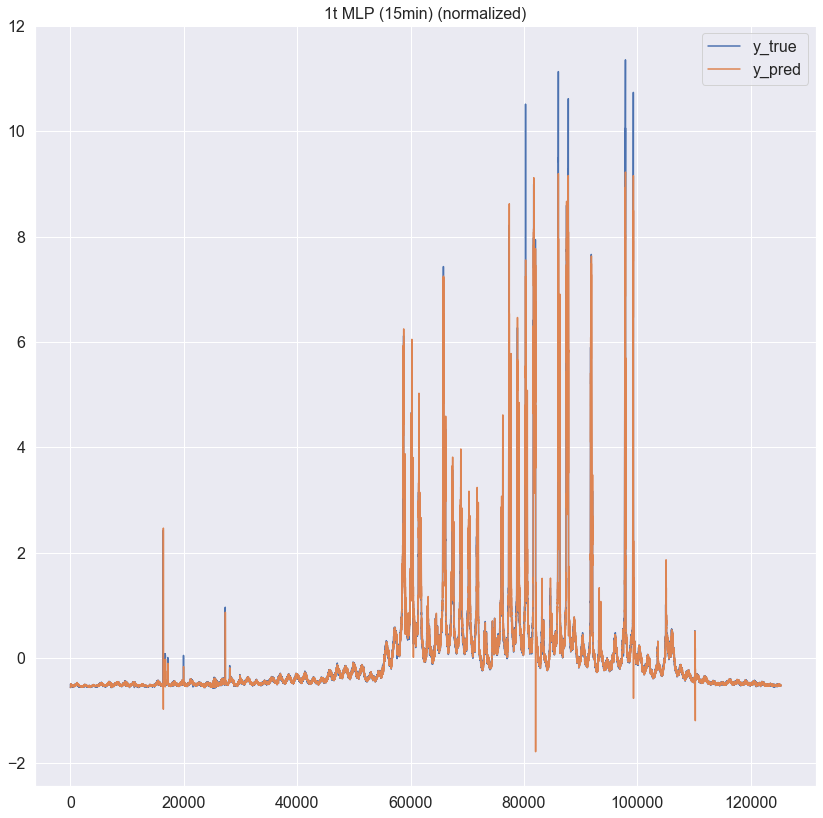

In [ ]:
#Generates a plot
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('1t MLP (15min) (normalized)')
plt.legend()
plt.savefig('1t MLP.15min.normalized.png')
# scaled_max = 100
# scaled_sub_df = (y_true / y_true.max() * scaled_max).apply(lambda x: round(x))
# scaled_sub_df['count'] = y_true.apply(lambda x: int(x))
#
# scaled_sub_df.plot()
# plt.savefig('sample.png')
# plt.show()
#
# print(scaled_sub_df['count'].values)

In [ ]:
csv_file = 'sharcnet_zscale.csv'
sharcnetdf = pd.read_csv(csv_file, index_col=0, parse_dates=True)
sharcnetdf = sharcnetdf.groupby('period').sum()
sharcnettraffic_df = sharcnetdf[['count']]
sharcnettraffic_df.loc[:,'previous'] = sharcnettraffic_df.loc[:,'count'].shift(15)
sharcnettraffic_df.loc[:,'difference'] = sharcnettraffic_df.loc[:,'previous'].diff(periods=1)
sharcnettraffic_df = sharcnettraffic_df.dropna()
X_sharcnet = sharcnettraffic_df.drop(['count'],axis = 1)
y_sharcnet = sharcnettraffic_df.loc[:, 'count']

In [ ]:
# nasay_true = y_nasa.values
# nasay_pred = best_model.predict(X_nasa)
#
# regression_metrics(nasay_true, nasay_pred)

sharcnety_true = y_sharcnet.values
sharcnety_pred = best_model.predict(X_sharcnet)

regression_metrics(sharcnety_true, sharcnety_pred)


<class 'ValueError'>
explained variance:  -0.4152
mean_absolute_score:  0.0047
mean squred error:  0.0
mean squared log error:  0.0
median absolute error:  0.0047
r-squared:  -21.9223


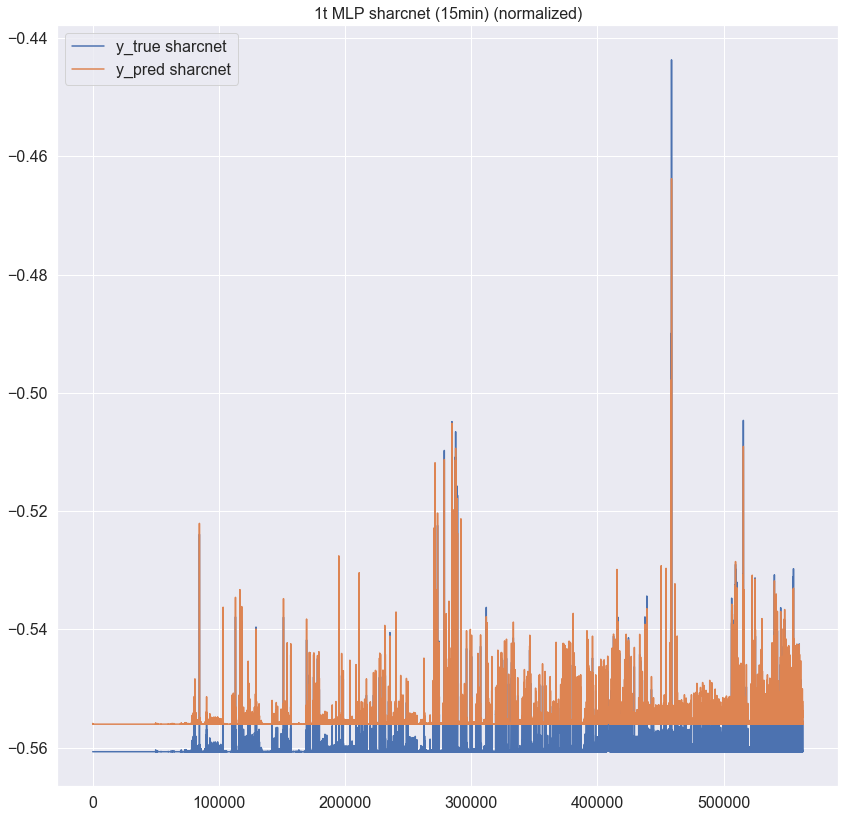

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.figure(figsize=(14,14))
plt.plot(sharcnety_true, label='y_true sharcnet')
plt.plot(sharcnety_pred, label='y_pred sharcnet')
plt.title('1t MLP sharcnet (15min) (normalized)')
plt.legend()
plt.savefig('1t MLP sharcnet.15min.normalized.png')
# scaled_max = 100
# scaled_sub_df = (y_true / y_true.max() * scaled_max).apply(lambda x: round(x))
# scaled_sub_df['count'] = y_true.apply(lambda x: int(x))
#
# scaled_sub_df.plot()
# plt.savefig('sample.png')
# plt.show()
#
# print(scaled_sub_df['count'].values)


explained variance: 1.0 is best https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score

mean absolute error: 0.0 is best https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score

mean squared error: 0.0 is best https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error

mean squared log error: 0.0 is best https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error

median absolute error: 0.0 is best https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html#sklearn.metrics.median_absolute_error

r2: 1.0 is best https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In [ ]:
traffic_df_v2 = traffic_df.copy()

traffic_df_v2['previous-1'] = traffic_df_v2['previous'].shift()
# traffic_df_v2['difference-1'] = traffic_df_v2['previous-1'].diff(periods=1)
traffic_df_v2['previous-2'] = traffic_df_v2['previous-1'].shift()
# traffic_df_v2['difference-2'] = traffic_df_v2['previous-2'].diff(periods=1)
traffic_df_v2 = traffic_df_v2.dropna()
traffic_df_v2

,count,previous,difference,previous-1,previous-2
period,,,,,
1998-04-30 21:34:00,3,7.0,-9.0,16.0,11.0
1998-04-30 21:35:00,2,3.0,-4.0,7.0,16.0
1998-04-30 21:36:00,3,2.0,-1.0,3.0,7.0
1998-04-30 21:37:00,4,3.0,1.0,2.0,3.0
1998-04-30 21:38:00,5,4.0,1.0,3.0,2.0
...,...,...,...,...,...
1998-07-26 21:55:00,777,667.0,81.0,586.0,585.0
1998-07-26 21:56:00,764,777.0,110.0,667.0,586.0
1998-07-26 21:57:00,821,764.0,-13.0,777.0,667.0


In [ ]:
X_train_v2 = traffic_df_v2[:'1998-04'].drop(['count'], axis=1)
y_train_v2 = traffic_df_v2.loc[:'1998-04', 'count']
# y_train_v2

X_test = traffic_df_v2['1998-05'].drop(['count'], axis=1)
y_test = traffic_df_v2.loc['1998-05', 'count']
# y_test

In [ ]:
#neural net
model = MLPRegressor(solver='lbfgs')
param_search = {
    'alpha' : [0.0001, 0.001, 0.01],
    'max_iter' : [1000, 10000, 100000],
}
# KNN
# model = KNeighborsRegressor(n_jobs=-1)
# param_search = {
#     'n_neighbors' : [3,5,10,20],
#     'weights' : ['uniform','distance'],
    # 'leaf_size' : [10,20,30,50],
    # 'p' : [1,2,3]
# }
#linear regressor
# model = LinearRegression(n_jobs=-1)
# param_search = {
#
# }
#random forest
# model = RandomForestRegressor(n_jobs=-1)
# param_search = {
#     'n_estimators' : [10,50,100],
#     'criterion' : ['mse','mae']
# }
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v2, y_train_v2)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_


In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)

<class 'ValueError'>
explained variance:  -2.9118
mean_absolute_score:  309.308
mean squred error:  4691291.0453
mean squared log error:  0.0
median absolute error:  144.7335
r-squared:  -2.912


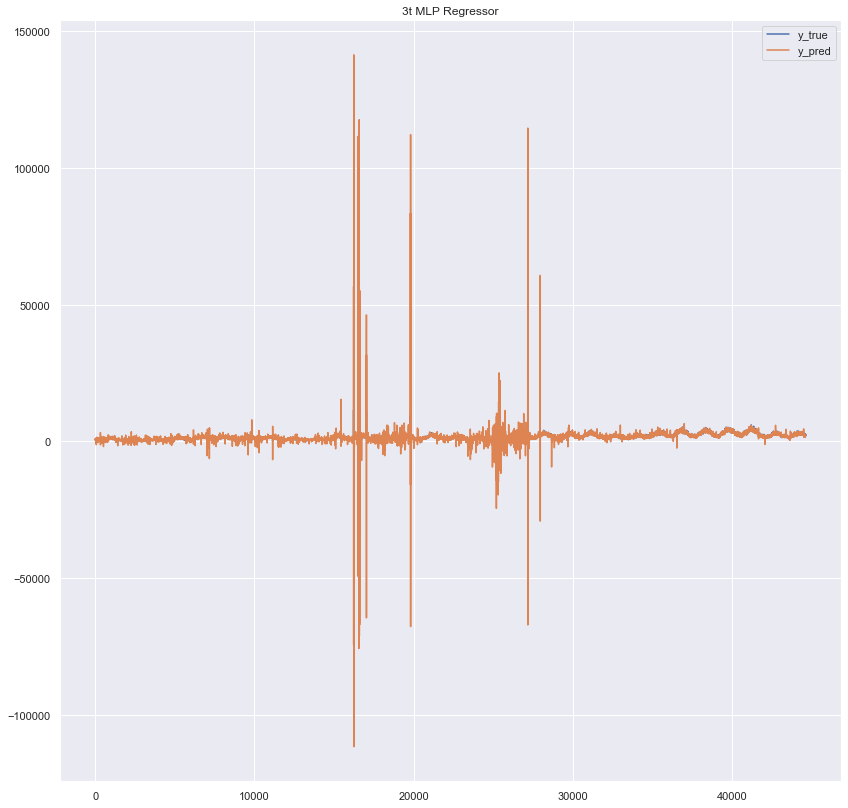

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('3t MLP Regressor')
plt.legend()
plt.savefig('3t MLP Regressor.png')

In [ ]:

#neural net
# model = MLPRegressor(solver='lbfgs')
# param_search = {
#     'alpha' : [0.0001, 0.001, 0.01],
#     'max_iter' : [1000, 10000, 100000],
# }
# KNN
model = KNeighborsRegressor(n_jobs=-1)
param_search = {
    'n_neighbors' : [3,5,10,20],
    'weights' : ['uniform','distance'],
    'leaf_size' : [10,20,30,50],
    'p' : [1,2,3]
}
#linear regressor
# model = LinearRegression(n_jobs=-1)
# param_search = {
#
# }
#random forest
# model = RandomForestRegressor(n_jobs=-1)
# param_search = {
#     'n_estimators' : [10,50,100],
#     'criterion' : ['mse','mae']
# }
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v2, y_train_v2)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_



In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)

explained variance:  0.0873
mean_absolute_score:  794.5903
mean squred error:  1586812.0577
mean squared log error:  0.5164
median absolute error:  458.3
r-squared:  -0.3232


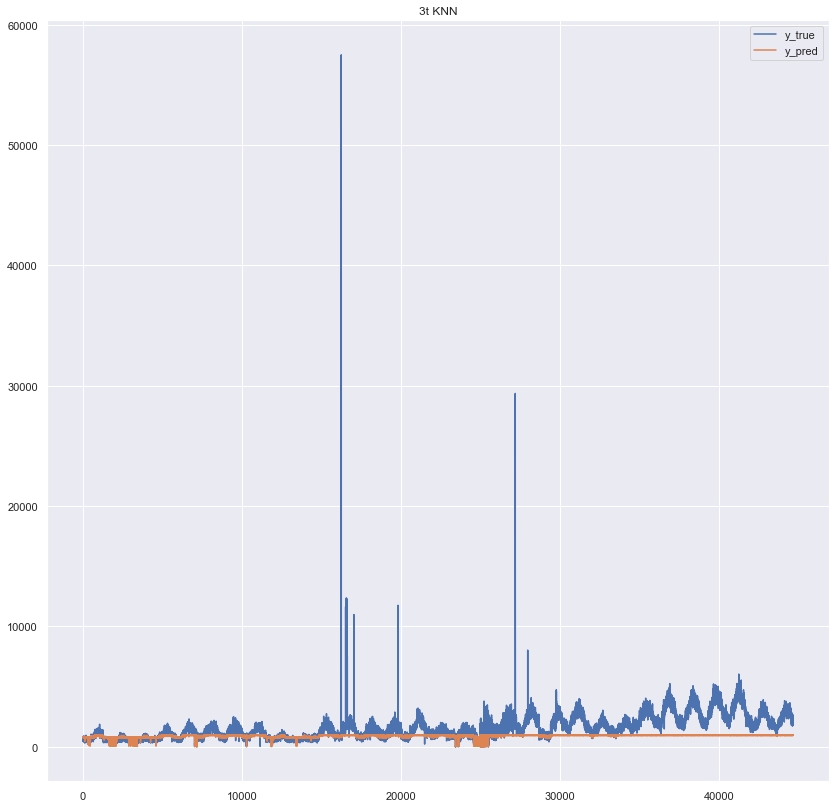

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('3t KNN')
plt.legend()
plt.savefig('3t KNN.png')

In [ ]:


#neural net
# model = MLPRegressor(solver='lbfgs')
# param_search = {
#     'alpha' : [0.0001, 0.001, 0.01],
#     'max_iter' : [1000, 10000, 100000],
# }
# KNN
# model = KNeighborsRegressor(n_jobs=-1)
# param_search = {
#     'n_neighbors' : [3,5,10,20],
#     'weights' : ['uniform','distance'],
    # 'leaf_size' : [10,20,30,50],
    # 'p' : [1,2,3]
# }
#linear regressor
# model = LinearRegression(n_jobs=-1)
# param_search = {
#
# }
#random forest
model = RandomForestRegressor(n_jobs=-1)
param_search = {
    'n_estimators' : [10,50,100],
    'criterion' : ['mse','mae']
}
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v2, y_train_v2)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_


In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)



explained variance:  0.0806
mean_absolute_score:  786.3135
mean squred error:  1568048.5223
mean squared log error:  0.4838
median absolute error:  451.45
r-squared:  -0.3076


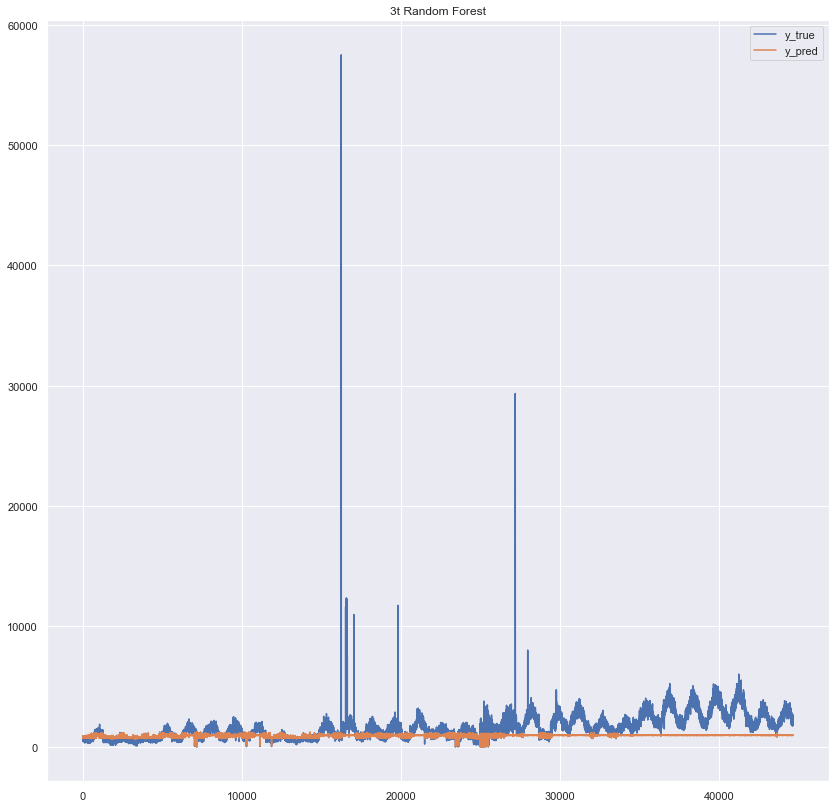

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('3t Random Forest')
plt.legend()
plt.savefig('3t Random Forest.png')

In [ ]:


#neural net
# model = MLPRegressor(solver='lbfgs')
# param_search = {
#     'alpha' : [0.0001, 0.001, 0.01],
#     'max_iter' : [1000, 10000, 100000],
# }
# KNN
# model = KNeighborsRegressor(n_jobs=-1)
# param_search = {
#     'n_neighbors' : [3,5,10,20],
#     'weights' : ['uniform','distance'],
    # 'leaf_size' : [10,20,30,50],
    # 'p' : [1,2,3]
# }
#linear regressor
model = LinearRegression(n_jobs=-1)
param_search = {

}
#random forest
# model = RandomForestRegressor(n_jobs=-1)
# param_search = {
#     'n_estimators' : [10,50,100],
#     'criterion' : ['mse','mae']
# }
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v2, y_train_v2)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_




In [ ]:

y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)




explained variance:  0.8515
mean_absolute_score:  173.1624
mean squred error:  181670.5794
mean squared log error:  0.0643
median absolute error:  117.1902
r-squared:  0.8485


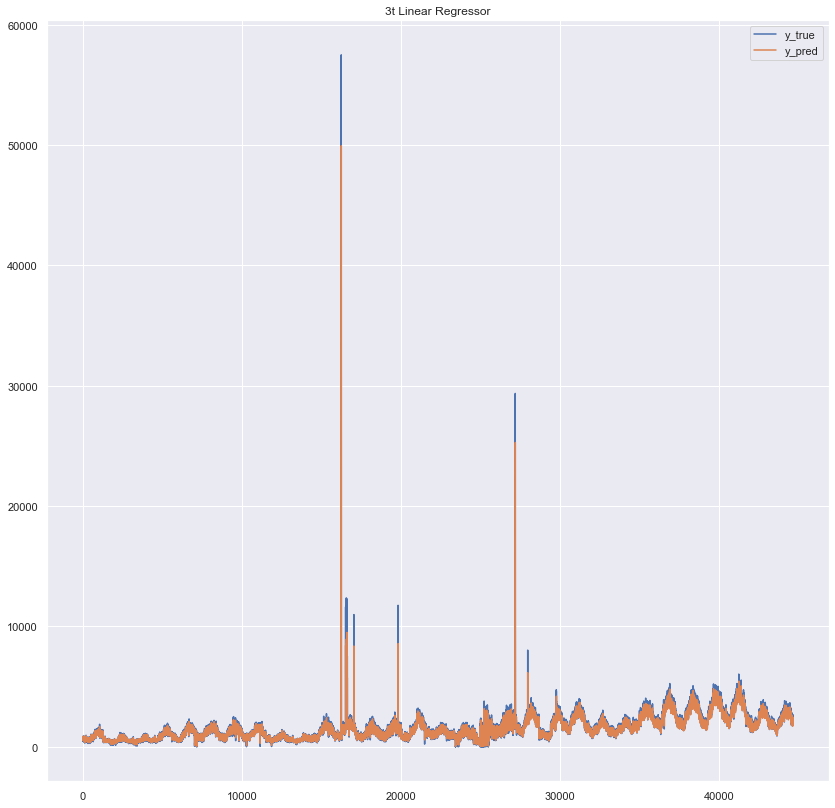

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('3t Linear Regressor')
plt.legend()
plt.savefig('3t Linear Regressor.png')

In [ ]:

traffic_df_v3 = traffic_df_v2.copy()

traffic_df_v3['previous-3'] = traffic_df_v3['previous-2'].shift()
# traffic_df_v3['difference-3'] = traffic_df_v3['previous-3'].diff(periods=1)
traffic_df_v3['previous-4'] = traffic_df_v3['previous-3'].shift()
# traffic_df_v3['difference-4'] = traffic_df_v3['previous-4'].diff(periods=1)
traffic_df_v3 = traffic_df_v3.dropna()
traffic_df_v3


,count,previous,difference,previous-1,previous-2,previous-3,previous-4
period,,,,,,,
1998-04-30 21:36:00,3,2.0,-1.0,3.0,7.0,16.0,11.0
1998-04-30 21:37:00,4,3.0,1.0,2.0,3.0,7.0,16.0
1998-04-30 21:38:00,5,4.0,1.0,3.0,2.0,3.0,7.0
1998-04-30 21:39:00,9,5.0,1.0,4.0,3.0,2.0,3.0
1998-04-30 21:40:00,1,9.0,4.0,5.0,4.0,3.0,2.0
...,...,...,...,...,...,...,...
1998-07-26 21:55:00,777,667.0,81.0,586.0,585.0,659.0,694.0
1998-07-26 21:56:00,764,777.0,110.0,667.0,586.0,585.0,659.0
1998-07-26 21:57:00,821,764.0,-13.0,777.0,667.0,586.0,585.0


In [ ]:

X_train_v3 = traffic_df_v3[:'1998-04'].drop(['count','difference'], axis=1)
y_train_v3 = traffic_df_v3.loc[:'1998-04', 'count']
# y_train_v3

X_test = traffic_df_v3['1998-05'].drop(['count','difference'], axis=1)
y_test = traffic_df_v3.loc['1998-05', 'count']
# y_test
# X_train_v3


In [ ]:

#neural net
model = MLPRegressor(solver='lbfgs')
param_search = {
    'alpha' : [0.0001, 0.001, 0.01],
    'max_iter' : [1000, 10000, 100000],
}
# KNN
# model = KNeighborsRegressor(n_jobs=-1)
# param_search = {
#     'n_neighbors' : [3,5,10,20],
#     'weights' : ['uniform','distance'],
    # 'leaf_size' : [10,20,30,50],
    # 'p' : [1,2,3]
# }
#linear regressor
# model = LinearRegression(n_jobs=-1)
# param_search = {
#
# }
#random forest
# model = RandomForestRegressor(n_jobs=-1)
# param_search = {
#     'n_estimators' : [10,50,100],
#     'criterion' : ['mse','mae']
# }
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v3, y_train_v3)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_



In [ ]:

y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)

<class 'ValueError'>
explained variance:  -2.1451
mean_absolute_score:  302.4531
mean squred error:  3771685.1229
mean squared log error:  0.0
median absolute error:  164.4978
r-squared:  -2.1452


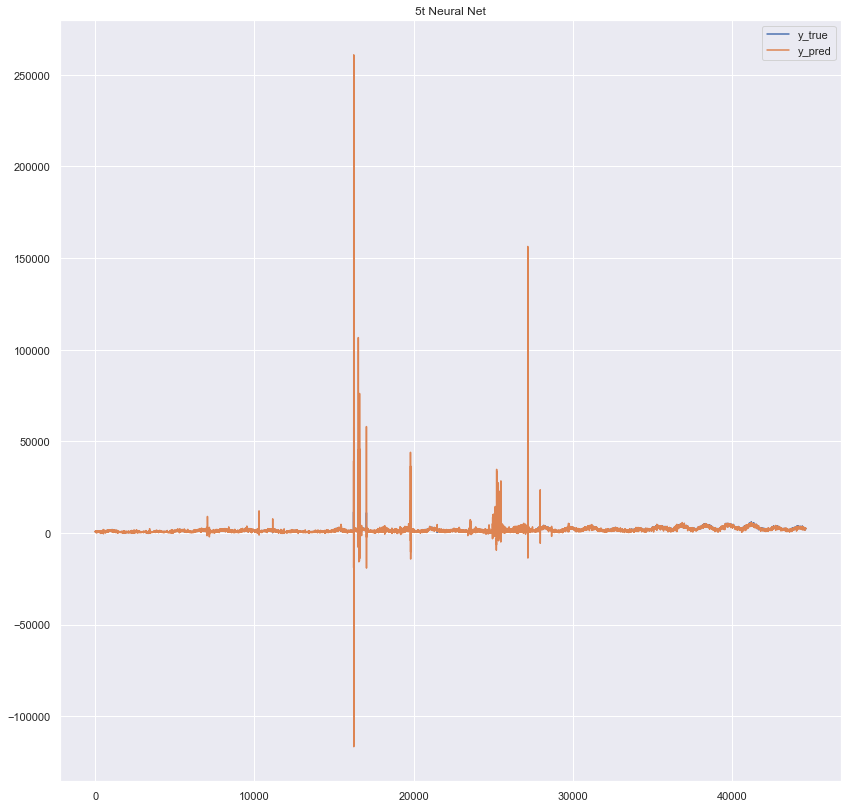

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('5t Neural Net')
plt.legend()
plt.savefig('5t Neural Net.png')


In [ ]:


#neural net
# model = MLPRegressor(solver='lbfgs')
# param_search = {
#     'alpha' : [0.0001, 0.001, 0.01],
#     'max_iter' : [1000, 10000, 100000],
# }
# KNN
model = KNeighborsRegressor(n_jobs=-1)
param_search = {
    'n_neighbors' : [3,5,10,20],
    'weights' : ['uniform','distance'],
    'leaf_size' : [10,20,30,50],
    'p' : [1,2,3]
}
#linear regressor
# model = LinearRegression(n_jobs=-1)
# param_search = {
#
# }
#random forest
# model = RandomForestRegressor(n_jobs=-1)
# param_search = {
#     'n_estimators' : [10,50,100],
#     'criterion' : ['mse','mae']
# }
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v3, y_train_v3)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_




In [ ]:


y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)


explained variance:  0.0716
mean_absolute_score:  808.6872
mean squred error:  1631159.5943
mean squared log error:  0.5386
median absolute error:  473.8911
r-squared:  -0.3602


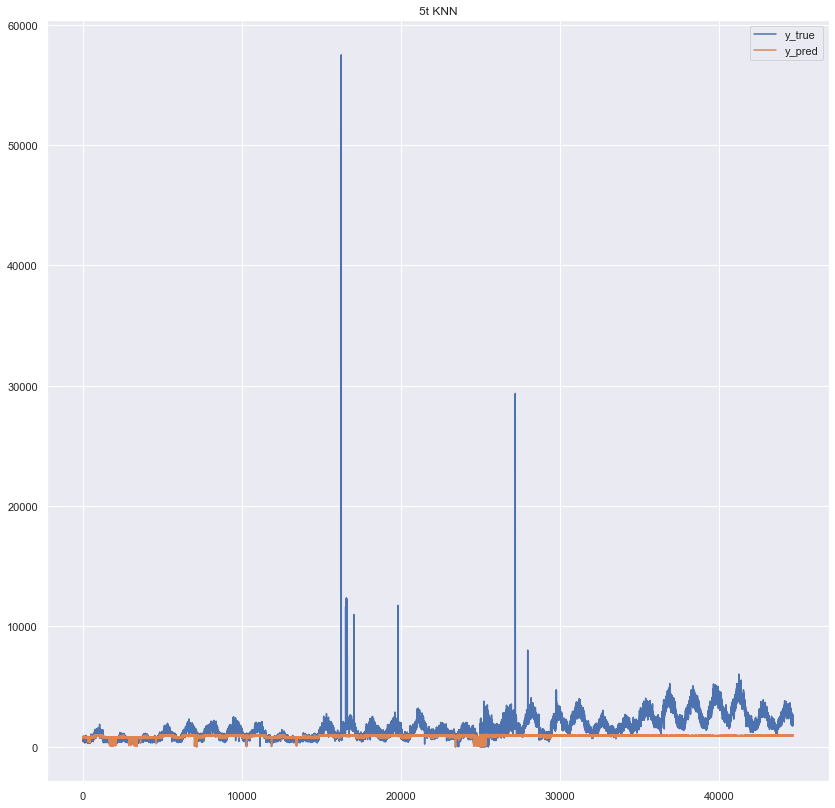

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('5t KNN')
plt.legend()
plt.savefig('5t KNN.png')


In [ ]:


#neural net
# model = MLPRegressor(solver='lbfgs')
# param_search = {
#     'alpha' : [0.0001, 0.001, 0.01],
#     'max_iter' : [1000, 10000, 100000],
# }
# KNN
# model = KNeighborsRegressor(n_jobs=-1)
# param_search = {
#     'n_neighbors' : [3,5,10,20],
#     'weights' : ['uniform','distance'],
    # 'leaf_size' : [10,20,30,50],
    # 'p' : [1,2,3]
# }
#linear regressor
model = LinearRegression(n_jobs=-1)
param_search = {

}
#random forest
# model = RandomForestRegressor(n_jobs=-1)
# param_search = {
#     'n_estimators' : [10,50,100],
#     'criterion' : ['mse','mae']
# }
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v3, y_train_v3)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_




In [ ]:


y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)


explained variance:  0.8527
mean_absolute_score:  172.758
mean squred error:  180197.6793
mean squared log error:  0.0664
median absolute error:  116.85
r-squared:  0.8497


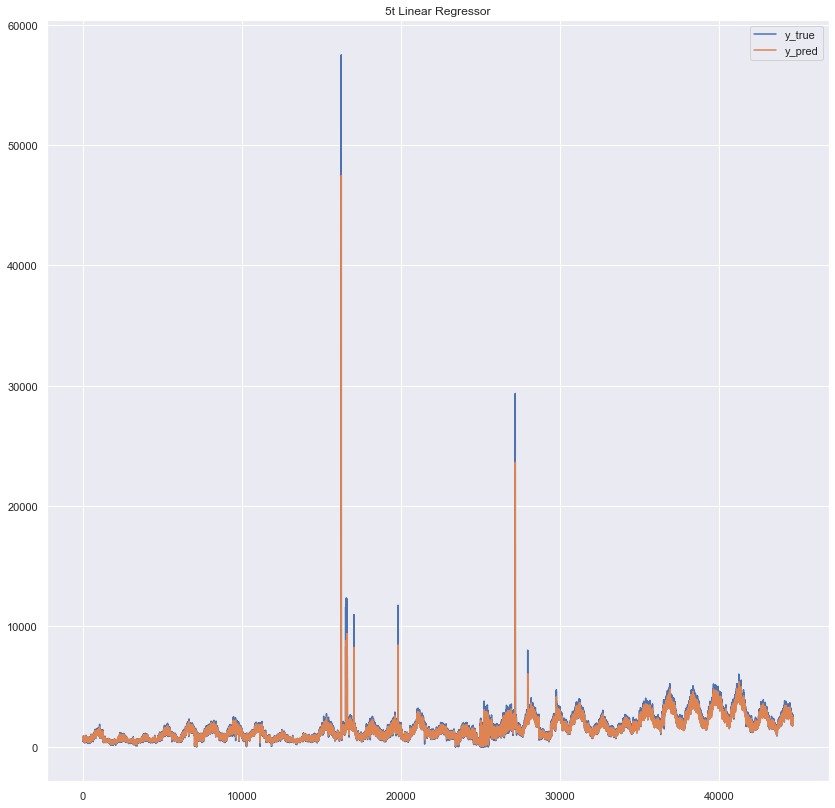

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('5t Linear Regressor')
plt.legend()
plt.savefig('5t Linear Regressor.png')


In [ ]:


#neural net
# model = MLPRegressor(solver='lbfgs')
# param_search = {
#     'alpha' : [0.0001, 0.001, 0.01],
#     'max_iter' : [1000, 10000, 100000],
# }
# KNN
# model = KNeighborsRegressor(n_jobs=-1)
# param_search = {
#     'n_neighbors' : [3,5,10,20],
#     'weights' : ['uniform','distance'],
    # 'leaf_size' : [10,20,30,50],
    # 'p' : [1,2,3]
# }
#linear regressor
# model = LinearRegression(n_jobs=-1)
# param_search = {
#
# }
#random forest
model = RandomForestRegressor(n_jobs=-1)
param_search = {
    'n_estimators' : [10,50,100],
    'criterion' : ['mse','mae']
}
#sVM
# model = SVR()
# param_search = {
#     'tol' : [0.1, 0.001, 0.0001],
#     'C' : [1,5,10]
# }

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v3, y_train_v3)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_




In [ ]:


y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)


explained variance:  0.0768
mean_absolute_score:  785.3105
mean squred error:  1551099.7054
mean squared log error:  0.4795
median absolute error:  449.64
r-squared:  -0.2934


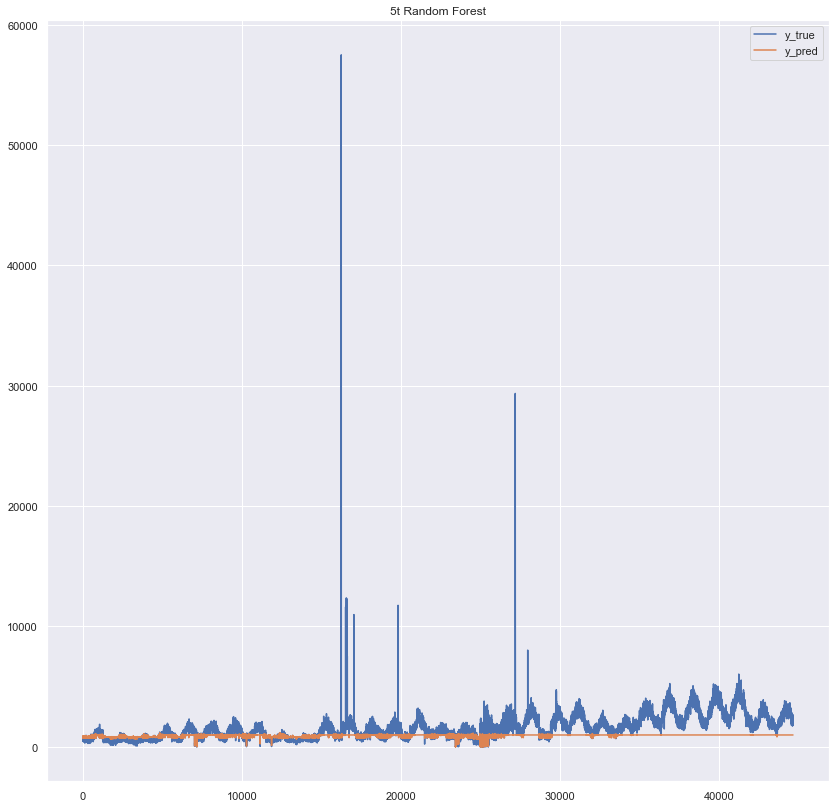

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('5t Random Forest')
plt.legend()
plt.savefig('5t Random Forest.png')


In [ ]:


#neural net
# model = MLPRegressor(solver='lbfgs')
# param_search = {
#     'alpha' : [0.0001, 0.001, 0.01],
#     'max_iter' : [1000, 10000, 100000],
# }
# KNN
# model = KNeighborsRegressor(n_jobs=-1)
# param_search = {
#     'n_neighbors' : [3,5,10,20],
#     'weights' : ['uniform','distance'],
    # 'leaf_size' : [10,20,30,50],
    # 'p' : [1,2,3]
# }
#linear regressor
# model = LinearRegression(n_jobs=-1)
# param_search = {
#
# }
#random forest
# model = RandomForestRegressor(n_jobs=-1)
# param_search = {
#     'n_estimators' : [10,50,100],
#     'criterion' : ['mse','mae']
# }
#sVM
model = SVR()
param_search = {
    'tol' : [0.1, 0.001, 0.0001],
    'C' : [1,5,10]
}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')

gsearch.fit(X_train_v3, y_train_v3)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_




In [ ]:


y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_metrics(y_true, y_pred)


explained variance:  -0.0337
mean_absolute_score:  949.0669
mean squred error:  2017075.1346
mean squared log error:  0.8782
median absolute error:  676.5357
r-squared:  -0.682


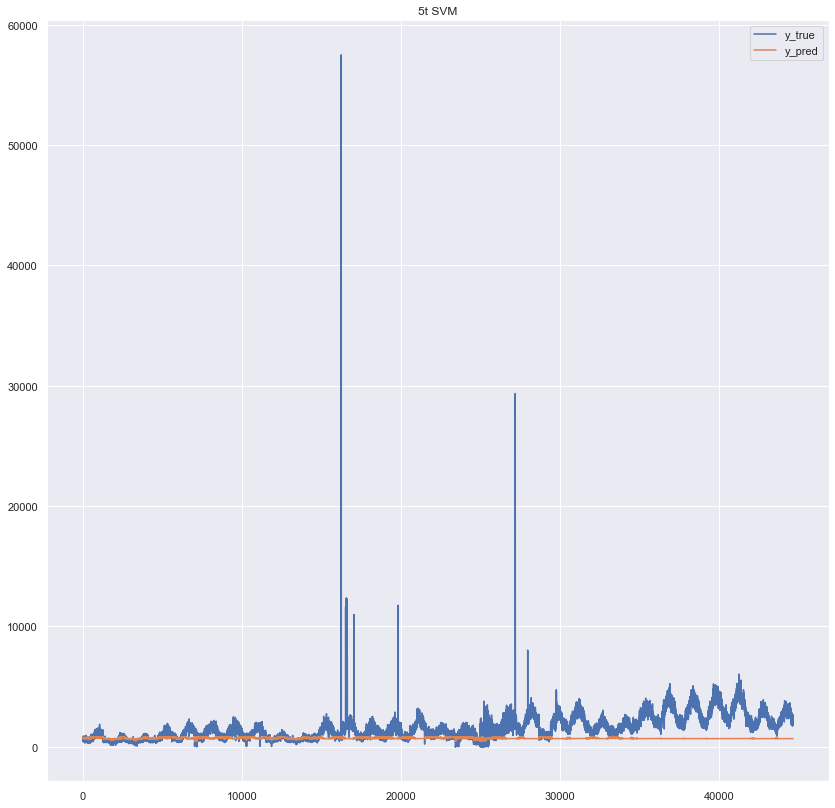

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.title('5t SVM')
plt.legend()
plt.savefig('5t SVM.png')


In [ ]:
results = []
names = []
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=30)

    cv_results = cross_val_score(model, X_train_v2, y_train_v2, cv=tscv, scoring='r2')

    results.append(cv_results)
    names.append(name)

    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: -2.271082 (4.488452)
NN: -6.612286 (16.644039)
KNN: -4.960132 (10.562062)
RF: -3.016166 (6.176395)
SVR: -31.396127 (78.312198)


In [ ]:
import numpy as np

imp = best_model.feature_importances_
features = X_train_v2.columns
indices = np.argsort(imp)

plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Facebook Prophet https://facebook.github.io/prophet/

In [ ]:
csv_file = 'invocation_count.csv'
prophet_df = pd.read_csv(csv_file)[44782:87982]
# df = df.groupby('period').sum()
# sub_df = df['1998-06-30 08:00:01':'1998-07-01 08:00:00']

# orig_df.head()
# prophet_df = orig_df.copy()
prophet_df.rename(columns={'period' : 'ds', 'count': 'y'}, inplace=True)


In [ ]:
import plotly
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import itertools

csv_file = 'invocation_count.csv'
prophet_df = pd.read_csv(csv_file)[44782:87982]
# df = df.groupby('period').sum()
# sub_df = df['1998-06-30 08:00:01':'1998-07-01 08:00:00']

# orig_df.head()
# prophet_df = orig_df.copy()
prophet_df.rename(columns={'period' : 'ds', 'count': 'y'}, inplace=True)
# prophet_df.head()
# m = Prophet()
# m.fit(prophet_df)

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

for params in all_params:
    m = Prophet(**params).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, initial='15 min', period='3 min', horizon='5 min', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
future = m.make_future_dataframe(periods=1)
future.tail()

,ds
43196,1998-06-30 23:58:00
43197,1998-06-30 23:59:00
43198,1998-07-01 00:00:00
43199,1998-07-01 00:01:00
43200,1998-07-02 00:01:00


In [ ]:
forecast = m.predict(future)
forecast

NameError: ignored

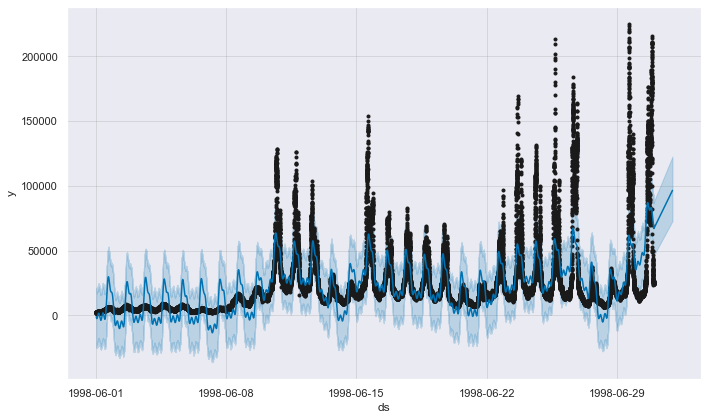

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
import pickle
pklpath='Prophet.pkl'
with open(pklpath,'wb') as f:
    pickle.dump(m,f)
forecast.to_pickle("forecast.pkl")
print('saved')

saved


In [ ]:
import pickle
pkl_path='Prophet.pkl'
with open(pkl_path, 'rb') as f:
    m = pickle.load(f)

forecast = pd.read_pickle("forecast.pkl")
forecast['yhat']

0        -1119.299774
1        -1183.600623
2        -1246.433846
3        -1307.796048
4        -1367.684218
             ...     
43196    67103.094516
43197    67060.291810
43198    67018.937811
43199    66979.037441
43200    96405.805151
Name: yhat, Length: 43201, dtype: float64

In [ ]:
prophet_df['y']


44782     1871
44783     2446
44784     2469
44785     2048
44786     1970
         ...  
87977    26320
87978    25080
87979    24221
87980    24481
87981    25154
Name: y, Length: 43200, dtype: int64

In [ ]:
regression_metrics(prophet_df['y'].tolist(),forecast['yhat'].tolist()[:-1])

<class 'ValueError'>
explained variance:  0.5711
mean_absolute_score:  10833.2658
mean squred error:  273295182.4425
mean squared log error:  0.0
median absolute error:  8076.6374
r-squared:  0.5711


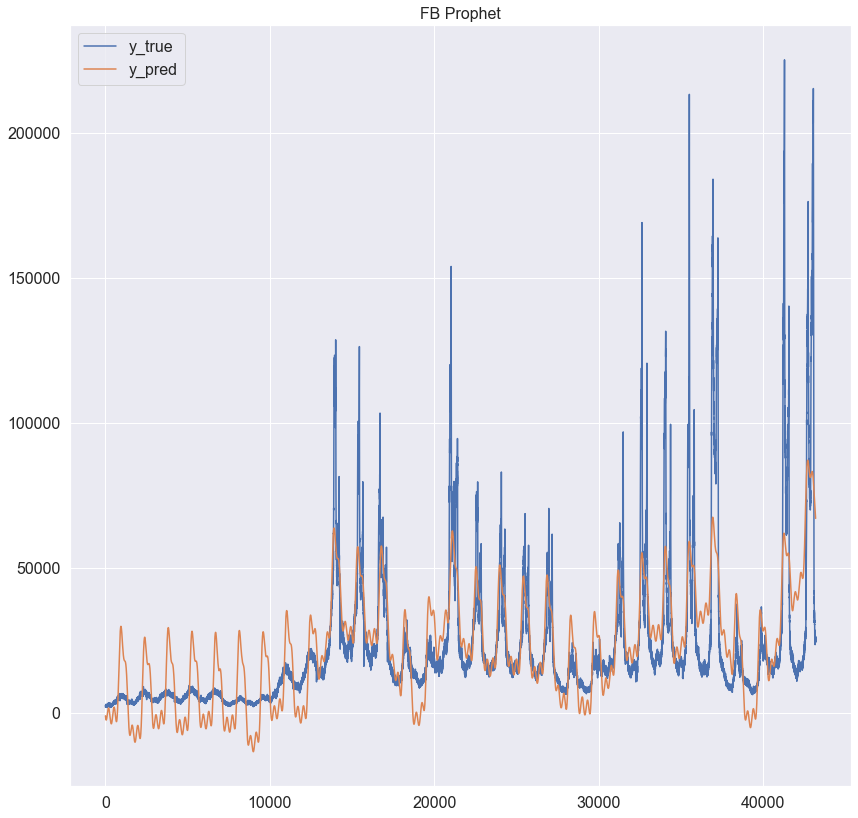

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(14,14))
plt.plot(prophet_df['y'].tolist(), label='y_true')
plt.plot(forecast['yhat'][:-1].tolist(), label='y_pred')
plt.title('FB Prophet')
plt.legend()
plt.savefig('FB Prophet.png')